In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Setup
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv('.env')

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

In [3]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage

# Define Graphstate
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        schema : Generated schema from json
        iterations : Number of tries
    """

    error: str
    messages: Sequence[BaseMessage] #changed from List
    block_schema: str
    iterations: int

    # messages: Sequence[BaseMessage] # TESTING

/Users/spark_near/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
# Load agents
from agents.planner import PlannerAgent, planner_init
from tools.JavaScriptRunner import tool_js_on_block, tool_js_on_block_schema
from langgraph.prebuilt import ToolExecutor

tools = [tool_js_on_block, tool_js_on_block_schema]
planner_model = planner_init(tools) 
planner = PlannerAgent(planner_model,ToolExecutor(tools))

In [9]:
# Conditional Edge logic
def should_tool_continue(state):
    messages = state['messages']
    block_schema = state['block_schema']
    last_message = messages[-1]
    iterations = state['iterations']
    if iterations > 3:
        return "end"
    elif block_schema == "":
        return "continue"
    elif "function_call" not in last_message.additional_kwargs:
        return "end"
    elif last_message.additional_kwargs['function_call']['name']=='Response':
        return "end"   
    else:
        return "end"

In [10]:
## Create Final Graph (will move this to another file ultimately)
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("planner", planner.plan_execution)  # Plan the process
# workflow.add_node("coder", coder)  # Codes what the planner directs
# workflow.add_node("reviewer", reviewer)  # Reviews the code

# Add human-in-the-loop node
workflow.add_node("human_review",planner.human_review)

## Define the Tool nodes
# workflow.add_node("query_blocks", planner.query_blocks)  # Tool to query blocks, skipped for now
workflow.add_node("get_block_schema", planner.get_block_schema)  # Tool to infer block schema
# workflow.add_node("test_code", reviewer.test_code)  # Tool to test code, skipped for now

## Add Edges
workflow.set_entry_point("planner")
# workflow.add_edge("query_blocks", "planner") # skip for now
workflow.add_edge("get_block_schema", "human_review")
workflow.add_edge("human_review", "planner")
# workflow.add_edge("coder", "reviewer")
# workflow.add_edge("test_code", "reviewer") # skip for now

# Add Conditional Edges
# Check if we should grab block schema from the planner node
workflow.add_conditional_edges(
    "planner",
    should_tool_continue,
    {
        "continue":"get_block_schema",
        "end": END
    }   
)

app = workflow.compile()

In [11]:
from langchain_core.messages import HumanMessage

question = "Build me an indexer on NEAR Blockchain for the receiver app.nearcrowd.near using block height 119688212"
result = app.invoke({"messages": [("user", question)], "block_schema": "", "iterations": 0})

In [16]:
result

{'error': 'Block schema is incorrect. Please review and try again',
 'messages': [('user',
   'Build me an indexer on NEAR Blockchain for the receiver app.nearcrowd.near using block height 119688212'),
  AIMessage(content="To build an indexer for the `app.nearcrowd.near` smart contract using block height 119688212, we will follow the steps outlined in the NEAR QueryAPI documentation. We will write custom logic in the `indexingLogic.js` file to extract and save relevant data to a GraphQL database defined in the `schema.sql` file.\n\nHere is the plan to create the indexer:\n\n1. **Extract Data from Block 119688212**:\n   - Use JavaScript code to extract relevant data from the block at height 119688212.\n   - Test the JavaScript code to ensure it works correctly.\n\n2. **Define Indexing Logic**:\n   - Write custom logic in the `indexingLogic.js` file to filter, transform, and save the extracted data.\n   - Use the extracted data to commit to the database.\n\n3. **Define Database Schema**:

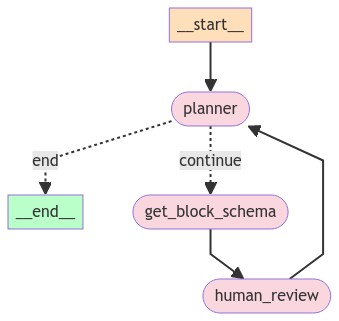

In [18]:
# Visualization
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))